In [175]:
# import necessary packages

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from  pyLDAvis import gensim_models

from gensim.similarities import MatrixSimilarity


In [239]:
# load unified token data
whisk_interdf_path = "data\\interim\\whisk_unified_tokenized.csv"
whisk_data = pd.read_csv(whisk_interdf_path)

In [3]:
# load reduced gensim dict
reduced_gensim_dict_path = "dictionaries\\reduced_gemsimdict_unified.pkl"
reduced_gensim_dict = pickle.load(open(reduced_gensim_dict_path, 'rb'))
print(reduced_gensim_dict)

Dictionary(477 unique tokens: ['barley', 'butter', 'cereal', 'cut_grass', 'fruit']...)


In [4]:
cols_to_keep = ['name', 'token_unified']
unitoken_df = whisk_data[cols_to_keep].set_index('name')

# entries in token_unified are strings. Literal evaluate to get this back into list of strings
attr_listed = [ast.literal_eval(row) for row in unitoken_df['token_unified'] ] 
unitoken_df['tokens'] = attr_listed
# get rid of original token unified column
unitoken_df.drop(columns = ['token_unified'], inplace = True)
unitoken_df.head()

,tokens
name,
Singleton of Dufftown 12 Year Old,"[orange_zest, malty_core, nut, oak, toffee, cu..."
Laphroaig 10 Year Old Sherry Oak Finish,"[roasted, cedar, peat_smoke, iodine, away, dar..."
GlenAllachie 15 Year Old,"[walnut, raisin, christmas, spice, fresh, ging..."
Seaweed & Aeons & Digging & Fire & Cask Strength 10 Year Old (Batch 04),"[coastal, core, solid, seaweed, salt, slightly..."
Edradour 10 Year Old,"[cloying, seductive, murky, rum, barley, almon..."


Create gensim corpus from reduced dictionary set.

In [9]:
corpus = [reduced_gensim_dict.doc2bow(doc) for doc in unitoken_df.tokens]

In [11]:
# lets pickle the whisky descriptor corpus (reference dictionary is reduced_gensim_dict):
pickle.dump(corpus, open('data\\final\\descriptor_corpus.pkl', 'wb'))

Of course, one of the big issues is that it's not clear what the best number of topics is a priori and whether the topics that an LDA model fits to are actually meaningful. We can use coherence measures (i.e. an aggregation of pairwise correlations between members of a topic as one measure). This can have some issues but its a way of putting a number on estimating topic coherence.

There are also other hyperparameters such as the alpha vector for the Dirichlet distribution.

In [6]:
# let's loop to extract the best hyperparameters and get the topic model coherence score for each hyperparameter set.
model_coherence_list = []
for topic_num in range(2,20, 1):
    # our LDA model
    scotch_topic_model = LdaModel(corpus = corpus, num_topics = topic_num, random_state=100,  id2word = reduced_gensim_dict, passes = 10, alpha = 'auto' )

    # coherence model wrapper
    cm = CoherenceModel(model=scotch_topic_model, texts= unitoken_df.tokens, coherence = 'c_v')
    model_coherence_list.append((topic_num, cm.get_coherence()))
    
print(model_coherence_list)


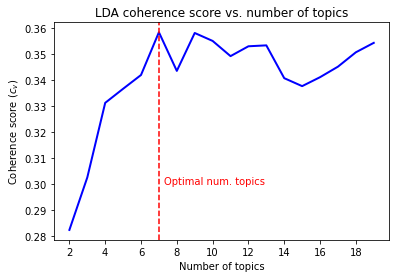

In [31]:
# plot model coherence score vs number of topics
unzipped_coherence_list = list(zip(*model_coherence_list))
plt.plot(unzipped_coherence_list[0], unzipped_coherence_list[1], c = 'b', linewidth = 2 )
plt.axvline(x = 7, c ='r', linestyle = '--')
plt.annotate('Optimal num. topics', xy = (7.3, 0.30), c ='r')
plt.title('LDA coherence score vs. number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score ($c_v$)')
plt.xticks(np.arange(2,20, 2))
plt.show()


In [6]:
scotch_topic_model = LdaModel(corpus = corpus, num_topics = 7, random_state=100,  id2word = reduced_gensim_dict, passes = 10, alpha = 'auto' )

In [7]:
scotch_topic_model.show_topics(num_words=30)

[(0,
  '0.044*"malt" + 0.044*"apple" + 0.043*"vanilla" + 0.041*"sweet" + 0.036*"cream" + 0.034*"spice" + 0.031*"oak" + 0.027*"fruit" + 0.023*"toffee" + 0.020*"finish" + 0.020*"honey" + 0.019*"barley" + 0.018*"butter" + 0.017*"cinnamon" + 0.016*"pepper" + 0.013*"rich" + 0.012*"custard" + 0.012*"spiced" + 0.012*"pear" + 0.011*"caramel" + 0.011*"long" + 0.010*"soft" + 0.010*"fresh" + 0.009*"nutmeg" + 0.009*"peel" + 0.009*"fudge" + 0.008*"allspice" + 0.008*"oil" + 0.008*"floral" + 0.007*"butterscotch"'),
 (1,
  '0.035*"chocolate" + 0.028*"cinnamon" + 0.020*"honey" + 0.018*"oak" + 0.018*"barley" + 0.015*"butter" + 0.015*"earth" + 0.015*"vanilla" + 0.013*"brown_sugar" + 0.013*"toasted" + 0.013*"ginger" + 0.012*"clove" + 0.012*"almond" + 0.012*"peppercorn" + 0.011*"caramel" + 0.011*"apricot" + 0.010*"layer" + 0.010*"black_pepper" + 0.009*"walnut" + 0.009*"subtle" + 0.009*"pineapple" + 0.009*"orange_peel" + 0.008*"plus" + 0.008*"later" + 0.008*"peanut" + 0.008*"background" + 0.008*"cedar" + 0.

In [226]:
vis = pyLDAvis.gensim_models.prepare(scotch_topic_model, corpus, reduced_gensim_dict, sort_topics = False)
pyLDAvis.display(vis)

C:\Users\prave\anaconda3\envs\sb_cpstone3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Let's look at this visualization at different values of relevance. At values of lambda = 1, we see that a common descriptor set tends to pile up at the highest saliency in all the topics. "Vanilla", "sweet", "oak", "fruit", "malt", "barley", "apple", etc. are examples of such ultra-common descriptors tht seem to be a unifying descriptor set for Scotch. We saw these same descriptors as the most frequent across Scotch regions during EDA. It's not too surprising that these words appear prelevantly in many of the descriptor topic groupings.

But restricting lambda to middle-range values (~0.4-0.6), we see that each topic has real differences and in ways that actually make some sense in terms of tastes.

Number in brackets are the index of each topic in the gensim model.

1. Topic 1 [0]: Custard, creamy, sticky toffee, pastry, etc along with a lot of common descriptors prominent here.
2. Topic 2 [1]: Fruity but with strong wood notes and heat or cooling on the tongue: peppercorn, black pepper, red chilies, ginger, warmth, mint, menthol, cedar, oak. Cinnamon, cassia, and clove are in here too.
3. Topic 3 [2]: Herbal, tannin, green, citrus, dry, smoke. Also many of the words that are not sense descriptors are huddled into a single topic. That's actually interesting. 
4. Topic 4 [3]: Sweetness and richness, dark sugars, with christmas spice like cinnamon, clove, etc but clearly in context.
5. Topic 5 [4]: Lemon, citrus, green apple, fresh notes, grass, light, floral, etc.
6. Topic 6 [5]: Berries, sweet chocolate, jam, fuit, tartness but sweet.
7. Topic 7 [6]: All the peaty, fiery, salty, meaty notes are prominent here.


A quick exploration of the visual shows that these topics are meaningful and overall pretty interpretable but that there are some confused descriptors that one might think would belong in a different topic. They are not as clean as one might hope. Topic 3 and Topic 5 have quite a bit of overlap. The same goes with topic 2 and 3. But the topics do line up with the kinds of thing we were seeing in Correspondence Analysis which is good. Getting better results might mean twiddling with the topic number a little, or just iterating over several random initializations at k = 7, or going back to corpus building and further tailoring the stop word list and stemming/lemmatizing. 

For this project, we'll stick with this model for now and see where it takes us.


In [8]:
doc_lda_decomp = scotch_topic_model[corpus] # for each document (scotch) creates a list of tuples for each scotch with the topic (taste type) and its relative importance.

This gives us a numeric breakdown of each scotch across different relevant taste/smell types as represented by the topics found by LDA. This is what we wanted and was something that the descriptor-scotch joint embedding via Correspondence Analysis could not give us.

Let's do a sanity check and see what we get for some well known Scotches:

1. Ardbeg 10 Year Old
My own experience with this whisky is that it tastes like smoked ham, peat, with some saltiness. Very fiery.

In [17]:
doc_num = whisk_data[whisk_data['name'] == 'Ardbeg 10 Year Old'].index[0]
print(doc_num)
doc_lda_decomp[doc_num]

48


[(0, 0.010454248), (6, 0.9521095)]

The topic decomposition reflects this.

2. Lagavulin 16 Year Old
Lagavulin is a really complex whisky. My own impressions are that it's smoky and there is some peat but it's also dark fruit notes, chocolate, aromatics like cloves. It's definitely rich but also somehow dry and peppery. 

In [58]:
doc_num = whisk_data[whisk_data['name'] == 'Lagavulin 16 Year Old'].index[0]
print(doc_num)
doc_lda_decomp[doc_num]

26


[(2, 0.4747394), (3, 0.3080656), (6, 0.201558)]

2 = dry, smoky, grass, citrus notes. 3 = christmas cake, aromatic spices, dark fruit, 6 = peat, salt, smoke, meat.

Not too shabby. We can see that there are different kinds of taste/smell types. There are strong flavors present here but there is a balance between these notes. That definitely is characteristic of Lagavulin.

3. Glenfarclas 15 Year Old
One of my favorite whiskies. This tastes like liquid christmas, sweetness, cinammon, spices. There's really no peat. 

In [49]:
doc_num = whisk_data[whisk_data['name'] == "Glenfarclas 15 Year Old"].index[0]
print(doc_num)
doc_lda_decomp[doc_num]

15


[(2, 0.23294689), (3, 0.73226655)]

3 = christmas cake, aromatic spices, dark fruit. Really dominates the descriptors which is about right. I'm not sure why 2 = grass, dry, smoky is in there...there's not a lot of grassy citrus notes. It might be that some of the non-taste/smell words are leaking in (which are also a major component of 2).

4. Talisker Storm

One description (not the Master of Malt description in our corpus) goes like this: 

Nose is delicate and soft with peat, smoke and sweetness.  Sea salt and honey with a soft fruity note.  Surprisingly sweet. Medium body with notes of peat, oak and honey sweetness.  A bit of a chilli bite mixed with smoke and hints of black pepper.  Bolder than what the nose suggested.  Lovely and warming on a cold Friday afternoon. 

In [130]:
doc_num = whisk_data[whisk_data['name'] == "Talisker Storm"].index[0]
doc_lda_decomp[doc_num]

[(1, 0.11187348), (2, 0.3725176), (6, 0.49300686)]

1 = Wood, red chili, ginger, pepper, hot spices. 2 = drier, light mellow fruit, grass, citrus flavors. 6 = peat, bonfire, salt, meat, coastal.

This topic breakdown on flavors/nose seem right. Predominantly coastal and peaty, soft fruit note, with some chili and black pepper heat. OK this is starting to satisfy me. Let's pickle the model.

In [131]:
LDA_model_path = "models\\Scotch_LDA.pkl"
pickle.dump(scotch_topic_model, open(LDA_model_path, 'wb'))

Let's also construct a new dataframe with the seven topics as features. We can discard the unified_tokens or BoW representation. This can be used for higher level analytics. We can the save this:

In [212]:
trial = [ (whisk_data.loc[doc].name, doc_lda_decomp[doc] ) for doc in whisk_data.index]

In [218]:
list(zip(trial[1]))

[(1,), ([(1, 0.35906678), (3, 0.14653125), (6, 0.4730465)],)]

## Similarity measures: Content-based recommender systems

In [118]:
index = MatrixSimilarity(doc_lda_decomp) 
sims = index[doc_lda_decomp[48]] 

In [121]:
# We'll reuse this index object for matrix similarity often for in-corpus recommendation. let's save this.
pickle.dump(index, open('data\\final\\index_sim.pkl', 'wb'))

### In-corpus recommendation

In [178]:
def get_similar_whiskies(name, num_rec, index_sim, data):

    doc_num = whisk_data[whisk_data['name'] == name].index[0]
    sims = index_sim[doc_lda_decomp[doc_num]]

    sorted_val_df = pd.Series(sims).sort_values(ascending = False).drop(index=doc_num).to_frame(name = "similarity")

    sorted_val_df['name'] = data.iloc[sorted_val_df.index].name.values
    
    # drop whiskies that have the same name and age expression.
    sorted_val_df.drop(index = sorted_val_df[sorted_val_df['name'].str.contains(name, flags=re.IGNORECASE, regex=True)].index, inplace = True)

    # "Glenmorangie The Quinta Ruban 14 Year Old"

    return sorted_val_df.name[0: num_rec]
    

In [179]:
get_similar_whiskies("Lagavulin 16 Year Old", 15, index, whisk_data)

5454                        Kilchoman Sherry Cask Release
5260    Benriach 13 Year Old Madeira Finish - Maderens...
4007    Caol Ila 34 Year Old 1982 - Small Batch (WM Ca...
5992                        Kilchoman Spring 2010 Release
5266    Benriach Arumaticus 12 Year Old (Dark Rum Finish)
3520                  Glen Grant 1952 (Gordon & MacPhail)
4451    Caol Ila 2001 (bottled 2013) Moscatel Cask Fin...
6454    Bunnahabhain 10 Year Old 2003 (cask 1153) - Ar...
5                                Bunnahabhain 12 Year Old
3227                                        Ardbeg Kelpie
4666    Dailuaine 15 Year Old 1997 - Single Cask (Mast...
7098                  Lp8 - Elements of Islay (Laphroaig)
2027               Ardbeg Kelpie - Committee Release 2017
5812                                    Ardbegg Eggeadail
4029    Port Ellen 32 Year Old 1983 - 15th Release (20...
Name: name, dtype: object

This is very good. Many of these whiskies have strong flavors but can be described as balanced between smoke, peat, salt, and dark aromatic spicy sweetness and bitter/dry citrus. How about another?

In [180]:
get_similar_whiskies("Glenfarclas 15 Year Old", 15, index, whisk_data)

7945        Macduff 13 Year Old 2003 (Single Cask Nation)
6414               Mortlach 20 Year Old 1978 - Rare Malts
5257                           Aberlour A'Bunadh Batch 42
5943    The Macallan in Lalique Spiritual Home 62 Year...
6343    Glen Grant 19 Year Old 1992 Cask 55402 - Cask ...
4846              Glenfarclas 1965 Family Cask Release IX
1422    Blair Athol 12 Year Old 2008 (cask 1) - Cask S...
4715              Glenfarclas 1986 Family Cask Release IX
8237    Edradour 10 Year Old 2010 (cask 385) - Un-Chil...
6127                        Bruichladdich 36 Year Old DNA
5348                                   Highland Park 1994
76                                Auchentoshan Three Wood
6406                  Bowmore 10 Year Old Devil's Casks I
7703      The GlenDronach 27 Year Old - Grandeur Batch 10
4750    Glen Grant 39 Year Old 1973 (cask 6582) - Mack...
Name: name, dtype: object

Wow. Arbelour A'bunadh is a whisky that I would have personally recommended to someone who has had and liked Glenfarclas 15. These recommendations are forward in christmas spice, dessert, dark and luxuriant sweetness. 

In [183]:
get_similar_whiskies("Glenmorangie The Quinta Ruban 14 Year Old", 15, index, whisk_data).values

array(['Ledaig 10 Year Old 2007 (cask 92721) - Dun Bheagan (Ian Macleod)',
       'Darkness! Aultmore 16 Year Old Oloroso Cask Finish',
       'Dailuaine 19 Year Old 1997 (casks 7207 & 7208) - Un-Chillfiltered Collection (Signatory)',
       'Balvenie Tun 1509 - Batch 5',
       'Mortlach 10 Year Old 2007 (cask 14406) - Old Malt Cask (Hunter Laing)',
       'Miltonduff 36 Year Old 1981 - North Star Spirits',
       'Miltonduff 21 Year Old 1995 (cask 13271) - Old Malt Cask (Hunter Laing)',
       'The GlenDronach 10 Year Old Port Wood',
       'Edradour 19 Year Old 1999 (casks 814 & 815) - Bordeaux Cask Finish',
       'Mortlach 12 Year Old 2007 (casks 304874 & 304875) - Un-Chillfiltered Collection (Signatory)',
       'Glenlossie 13 Year Old 2007 (casks 3955 & 3956) - Un-Chillfiltered Collection (Signatory)',
       'Glenturret 29 Year Old 1988 (cask 539) - Cask Strength Collection (Signatory)',
       'Auchroisk 21 Year Old Moscatel Cask Finish (Darkness)',
       'GlenAllachie 11 Yea

Quinta Ruban is forward in red berries, peach, raisin type tastes: sweet but tart and jammy (topic indexed by 5). Some heat (topic 1), dry citrus (topic 2), and creamy vanilla (topic 0). Many of the whiskies on this list have similar taste profiles.

In [184]:
doc_num = whisk_data[whisk_data['name'] == "Glenmorangie The Quinta Ruban 14 Year Old"].index[0]
doc_lda_decomp[doc_num]

[(0, 0.23477353), (1, 0.27970412), (2, 0.12378674), (5, 0.34624907)]

Let's take a look and some of these:

In [203]:
print('Darkness! Aultmore 16 Year Old Oloroso Cask Finish:')
print(whisk_data[whisk_data['name'] == 'Darkness! Aultmore 16 Year Old Oloroso Cask Finish'].token_unified.values)
print('Balvenie Tun 1509 - Batch 5:')
print(whisk_data[whisk_data['name'] == 'Balvenie Tun 1509 - Batch 5'].token_unified.values)
print('Edradour 19 Year Old 1999 (casks 814 & 815) - Bordeaux Cask Finish:')
print(whisk_data[whisk_data['name'] == 'Edradour 19 Year Old 1999 (casks 814 & 815) - Bordeaux Cask Finish'].token_unified.values)



Darkness! Aultmore 16 Year Old Oloroso Cask Finish:
["['oooh', 'like', 'tuck', 'shop', 'bag', 'chew', 'toffee', 'chocolate', 'raisin', 'subtle', 'red_chilli', 'mid', 'cherry', 'baked', 'apple', 'freshly', 'bread', 'milka', 'chocolate', 'bar', 'long', 'sweet', 'blackcurrant', 'oak']"]
Balvenie Tun 1509 - Batch 5:
["['vanilla', 'ice_cream', 'raspberry', 'sauce', 'nut', 'juicy', 'apple', 'apricot', 'slow_build', 'sweet', 'spice', 'sherried_peel', 'acacia_honey', 'new_leather', 'raspberry', 'eau', 'de', 'vie', 'earth', 'malt', 'brown_sugar', 'red_berry', 'smidge', 'toasted', 'oak', 'stem_ginger']"]
Edradour 19 Year Old 1999 (casks 814 & 815) - Bordeaux Cask Finish:
["['ripe', 'plum', 'damson', 'cinnamon', 'custard', 'anise', 'clove', 'bakewell', 'tart', 'blackcurrant_jam', 'cream', 'mocha', 'toasted_teacake', 'heap', 'chai', 'spice', 'dr', 'oak', 'orange_oil', 'hefty', 'slice', 'black', 'forest', 'gateau']"]
